# MA 再評価

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.ios import get_excel_sheet
from funcs.technical import CappedTrendAccumulator, MovingAverage
from funcs.tide import conv_datetime_from_timestamp

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## ティックデータの取得

In [4]:
#excel = "ticks_20251212.xlsx"
# excel = "ticks_20251229.xlsx"
excel = "ticks_20251230.xlsx"
code = "7011"  # 銘柄コード

path_dir = os.path.join("..", "collection")
path_excel = os.path.join(path_dir, excel)
df = get_excel_sheet(path_excel, code)
df

,Time,Price,Volume
0,1.767053e+09,3850,314100
1,1.767053e+09,3850,314100
2,1.767053e+09,3857,344900
3,1.767053e+09,3857,344900
4,1.767053e+09,3847,371300
...,...,...,...
19439,1.767076e+09,3844,8350600
19440,1.767076e+09,3844,8350600
19441,1.767076e+09,3844,8350600
19442,1.767076e+09,3844,8361300


In [5]:
df.index = [pd.to_datetime(conv_datetime_from_timestamp(ts)) for ts in df["Time"]]
df

,Time,Price,Volume
2025-12-30 09:00:04,1.767053e+09,3850,314100
2025-12-30 09:00:05,1.767053e+09,3850,314100
2025-12-30 09:00:06,1.767053e+09,3857,344900
2025-12-30 09:00:07,1.767053e+09,3857,344900
2025-12-30 09:00:08,1.767053e+09,3847,371300
...,...,...,...
2025-12-30 15:24:45,1.767076e+09,3844,8350600
2025-12-30 15:24:46,1.767076e+09,3844,8350600
2025-12-30 15:24:47,1.767076e+09,3844,8350600
2025-12-30 15:24:48,1.767076e+09,3844,8361300


## 2つの移動平均とクロス処理

In [22]:
# 2つの移動平均
n_1 = 60
ma_1 = MovingAverage(window_size=n_1)
df["MA1"] = [ma_1.update(v) for v in df["Price"]]
n_2 = 900
ma_2 = MovingAverage(window_size=n_2)
df["MA2"] = [ma_2.update(v) for v in df["Price"]]
# ２つの MA の差分
df["DMA"] = df["MA1"] - df["MA2"]
# ============================
# 1. クロス検出（+1 / -1 / 0）
# ============================
golden = ((df["DMA"].shift(1) < 0) & (df["DMA"] > 0)).astype(int)
dead = ((df["DMA"].shift(1) > 0) & (df["DMA"] < 0)).astype(int) * -1
df["Cross"] = (golden + dead).astype("int8")  # 軽量で扱いやすい
# ============================
# 2. 傾き（diff → 軽い平滑化）
# ============================
df["Slope_MA1"] = df["MA1"].diff().rolling(5).mean()
# ============================
# 3. 傾きの強さフィルタ（MA1）
# ============================
threshold = 0.025
df["Strong_Slope"] = df["Slope_MA1"].abs() > threshold
# ============================
# 4. 最終エントリー条件
# ============================
df["Entry"] = (
    (df["Cross"] != 0)
    & df["Strong_Slope"]
)
df

,Time,Price,Volume,MA1,MA2,DMA,Cross,Slope_MA1,Strong_Slope,Entry,CTA
2025-12-30 09:00:04,1.767053e+09,3850,314100,3850.000000,3850.000000,0.000000,0,NaN,False,False,0.0
2025-12-30 09:00:05,1.767053e+09,3850,314100,3850.000000,3850.000000,0.000000,0,NaN,False,False,0.0
2025-12-30 09:00:06,1.767053e+09,3857,344900,3852.333333,3852.333333,0.000000,0,NaN,False,False,2.0
2025-12-30 09:00:07,1.767053e+09,3857,344900,3853.500000,3853.500000,0.000000,0,NaN,False,False,2.0
2025-12-30 09:00:08,1.767053e+09,3847,371300,3852.200000,3852.200000,0.000000,0,NaN,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-30 15:24:45,1.767076e+09,3844,8350600,3845.450000,3845.738889,-0.288889,0,-0.030000,True,False,1.0
2025-12-30 15:24:46,1.767076e+09,3844,8350600,3845.433333,3845.734444,-0.301111,0,-0.026667,True,False,1.0
2025-12-30 15:24:47,1.767076e+09,3844,8350600,3845.400000,3845.730000,-0.330000,0,-0.023333,False,False,1.0
2025-12-30 15:24:48,1.767076e+09,3844,8361300,3845.383333,3845.725556,-0.342222,0,-0.020000,False,False,1.0


In [23]:
# Capped Price Movement
n_3 = 30
cta = CappedTrendAccumulator(window_size=n_3)
df["CTA"] = [cta.update(v) for v in df["Price"]]
df

,Time,Price,Volume,MA1,MA2,DMA,Cross,Slope_MA1,Strong_Slope,Entry,CTA
2025-12-30 09:00:04,1.767053e+09,3850,314100,3850.000000,3850.000000,0.000000,0,NaN,False,False,0.0
2025-12-30 09:00:05,1.767053e+09,3850,314100,3850.000000,3850.000000,0.000000,0,NaN,False,False,0.0
2025-12-30 09:00:06,1.767053e+09,3857,344900,3852.333333,3852.333333,0.000000,0,NaN,False,False,2.0
2025-12-30 09:00:07,1.767053e+09,3857,344900,3853.500000,3853.500000,0.000000,0,NaN,False,False,2.0
2025-12-30 09:00:08,1.767053e+09,3847,371300,3852.200000,3852.200000,0.000000,0,NaN,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-12-30 15:24:45,1.767076e+09,3844,8350600,3845.450000,3845.738889,-0.288889,0,-0.030000,True,False,1.0
2025-12-30 15:24:46,1.767076e+09,3844,8350600,3845.433333,3845.734444,-0.301111,0,-0.026667,True,False,1.0
2025-12-30 15:24:47,1.767076e+09,3844,8350600,3845.400000,3845.730000,-0.330000,0,-0.023333,False,False,1.0
2025-12-30 15:24:48,1.767076e+09,3844,8361300,3845.383333,3845.725556,-0.342222,0,-0.020000,False,False,1.0


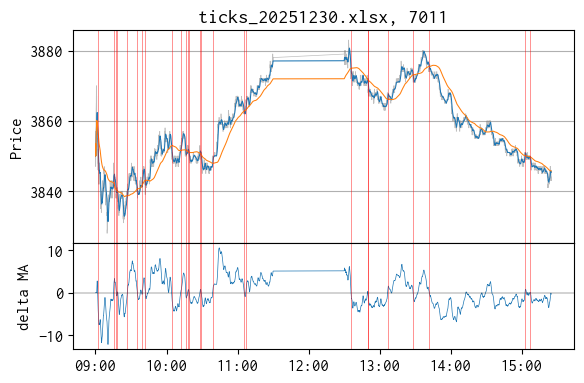

In [24]:
fig = plt.figure(figsize=(6, 4))
n = 2
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis

ax[0].plot(df["Price"], linewidth=0.5, color="gray", alpha=0.5)
ax[0].plot(df["MA1"], linewidth=0.75)
ax[0].plot(df["MA2"], linewidth=0.75)
ax[0].set_ylabel("Price")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_title(f"{excel}, {code}")
ax[0].grid(axis="y")

ax[1].plot(df["DMA"], linewidth=0.5)
ax[1].axhline(0, linewidth=0.25, color="black")
ax[1].set_ylabel("delta MA")

entry_times = df.index[df["Entry"]]
for t in entry_times:
    ax[0].axvline(t, color="red", linewidth=0.5, alpha=0.6)
    ax[1].axvline(t, color="red", linewidth=0.5, alpha=0.6)

plt.tight_layout()
output = os.path.join("..", "tmp", "dma.png")
plt.savefig(output)
plt.show()

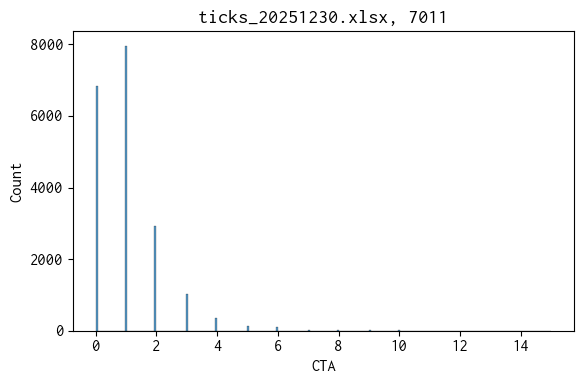

In [9]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df, x="CTA", line_kws={"linewidth": 2}, ax=ax)
ax.set_title(f"{excel}, {code}")

plt.tight_layout()
output = os.path.join("..", "tmp", "cta_hist.png")
plt.savefig(output)
plt.show()